In [ ]:
!sudo apt-get update
!sudo apt-get install texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,192 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,626 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubunt

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from statsmodels.graphics.gofplots import qqplot

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

ts_fig = (16, 4)
dis_fig = (4, 3)

# Preliminary data exploration

In [ ]:
df = pd.read_csv("./project_data.csv")
df['temp'] = df.apply(lambda x: x['NA_MaxT'] - 273.15, axis=1)
df['dt'] = pd.to_datetime(df['dt'])
df['yr'] = df['yr'].astype(int)
df['dt_str'] = df['dt'].astype(str)
df

,yr,mon,day,NA_MaxT,dt,temp,dt_str
0,1979,1.0,1,292.018188,1979-01-01,18.868188,1979-01-01
1,1979,1.0,2,292.338226,1979-01-02,19.188226,1979-01-02
2,1979,1.0,3,292.806000,1979-01-03,19.656000,1979-01-03
3,1979,1.0,4,292.695221,1979-01-04,19.545221,1979-01-04
4,1979,1.0,5,293.686157,1979-01-05,20.536157,1979-01-05
...,...,...,...,...,...,...,...
14240,2017,12.0,27,295.715027,2017-12-27,22.565027,2017-12-27
14241,2017,12.0,28,295.725006,2017-12-28,22.575006,2017-12-28
14242,2017,12.0,29,295.335327,2017-12-29,22.185327,2017-12-29
14243,2017,12.0,30,295.497192,2017-12-30,22.347192,2017-12-30


In [ ]:
x, y, dt = df.index.to_numpy(), df['temp'].to_numpy(), df['dt'].values

split_idx = 13000
x_train, y_train, dt_train = x[:split_idx], y[:split_idx], dt[:split_idx]
x_test, y_test, dt_test = x[split_idx:], y[split_idx:], dt[split_idx:]
print(f"Train: {len(y_train)}, Test: {len(y_test)}, Date: {dt[split_idx]}")

Train: 13000, Test: 1245, Date: 2014-08-05T00:00:00.000000000


In [ ]:
df.describe()

,yr,mon,day,NA_MaxT,dt,temp
count,14245.00000,14245.000000,14245.000000,14245.000000,14245,14245.000000
mean,1998.00000,6.522850,15.729870,298.151929,1998-07-02 00:00:00,25.001929
min,1979.00000,1.000000,1.000000,286.160431,1979-01-01 00:00:00,13.010431
25%,1988.00000,4.000000,8.000000,294.422516,1988-10-01 00:00:00,21.272516
50%,1998.00000,7.000000,16.000000,298.050903,1998-07-02 00:00:00,24.900903
75%,2008.00000,10.000000,23.000000,302.164368,2008-04-01 00:00:00,29.014368
max,2017.00000,12.000000,31.000000,306.082428,2017-12-31 00:00:00,32.932428
std,11.25519,3.448846,8.800499,4.098664,NaN,4.098664


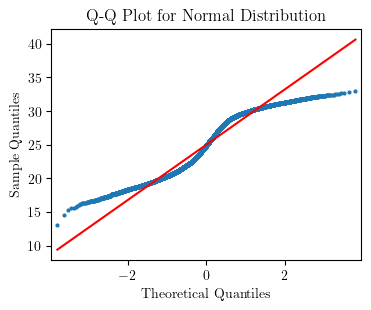

In [ ]:
fig, ax = plt.subplots(figsize=dis_fig)
qqplot(y, line='s', ax=ax, markersize=2)
plt.title('Q-Q Plot for Normal Distribution')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
fig.savefig("Figure 1 (a).svg", format='svg', bbox_inches='tight')

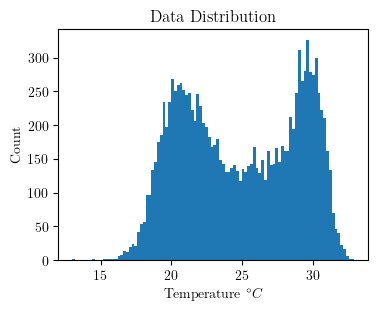

In [ ]:
plt.figure(figsize=dis_fig)
plt.hist(y_train, bins=100)
plt.title('Data Distribution')
plt.xlabel(r'Temperature $^\circ C$')
plt.ylabel('Count')
plt.gcf().savefig("Figure 1 (b).svg", format='svg', bbox_inches='tight')
plt.show()

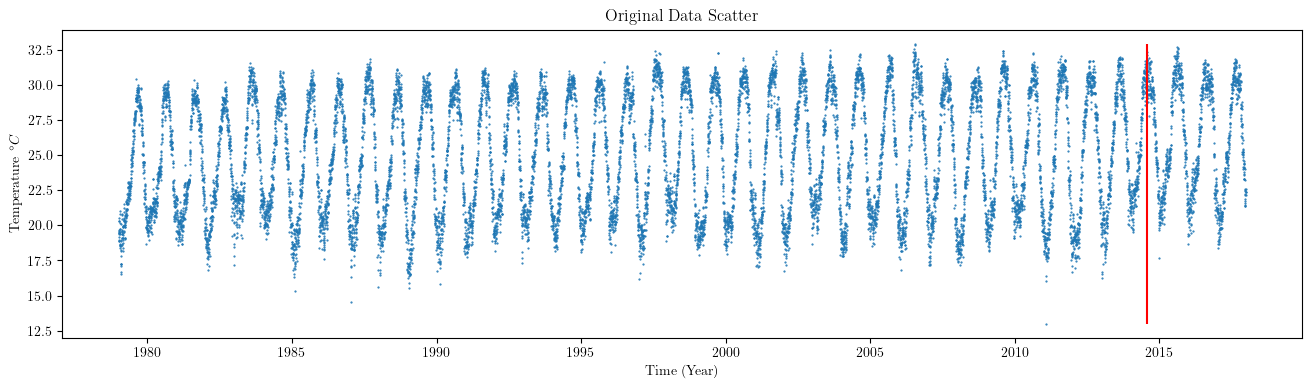

In [ ]:
plt.figure(figsize=ts_fig)
# plt.scatter(dt_train, y_train, s=0.3)
plt.scatter(dt, y, s=0.3)
plt.vlines(dt[split_idx], min(y), max(y), color="red")
plt.title('Original Data Scatter')
plt.xlabel('Time (Year)')
plt.ylabel(r'Temperature $^\circ C$')
plt.gcf().savefig("Figure 1 (c).svg", format='svg', bbox_inches='tight')
plt.show()

# Trend component

In [ ]:
def calculate_rss(y_true, y_pred):
    residuals = y_true - y_pred
    rss = np.sum(residuals**2)
    return rss


def calculate_rse(y_true, y_pred, num_params):
    n = len(y_true)
    rss = calculate_rss(y_true, y_pred)
    degrees_of_freedom = n - num_params
    mse = rss / degrees_of_freedom
    rse = np.sqrt(mse)
    return rse


def calculate_ssr(y_true, y_pred):
    mean_y = np.mean(y_true)
    ssr = np.sum((y_pred - mean_y)**2)
    return ssr


def calculate_r2(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true))**2)
    ss_residual = calculate_rss(y_true, y_pred)
    r2 = 1 - (ss_residual / ss_total)
    return r2


def calculate_f_statistic(y_true, y_pred, num_params):
    n = len(y_true)
    ssr = calculate_ssr(y_true, y_pred)
    rss = calculate_rss(y_true, y_pred)
    k = num_params
    f_statistic = (ssr / k) / (rss / (n - k - 1))
    p_value = 1 - stats.f.cdf(f_statistic, k, n - k - 1)
    return f_statistic, p_value

def calculate_aic_bic(y_true, y_pred, num_params):
    n = len(y_true)
    residuals = y_true - y_pred
    sigma = np.std(residuals)
    log_likelihood = calculate_log_likelihood(y_true, y_pred, sigma)

    aic = 2 * num_params - 2 * log_likelihood
    bic = num_params * np.log(n) - 2 * log_likelihood

    return aic, bic

def calculate_log_likelihood(y_true, y_pred, sigma):
    n = len(y_true)
    log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(sigma**2) - 0.5 * np.sum(((y_true - y_pred) / sigma)**2)
    return log_likelihood

In [ ]:
def calculate_detrend(x, y, params):
    z = np.polyfit(x, y, params)
    p = np.poly1d(z)

    rse = calculate_rse(y, p(x), num_params=len(z))
    r2 = calculate_r2(y, p(x))
    f_stat, p_value = calculate_f_statistic(y, p(x), num_params=len(z))

    aic, bic = calculate_aic_bic(y, p(x), len(z))
    print(f"poly: {params}, rse: {rse:.5f}, r2: {r2:.3f}, f_stat: {f_stat:.5f}, p-value: {p_value:.5f}, AIC: {aic}, BIC: {bic}")

In [ ]:
for i in range(0, 5):
    calculate_detrend(x_train, y_train, i)

poly: 0, rse: 4.11114, r2: 0.000, f_stat: 0.00000, p-value: 1.00000, AIC: 73649.60955895996, BIC: 73657.0822635964
poly: 1, rse: 4.09127, r2: 0.010, f_stat: 63.78799, p-value: 0.00000, AIC: 73524.62634334754, BIC: 73539.57175262042
poly: 2, rse: 4.08886, r2: 0.011, f_stat: 48.01748, p-value: 0.00000, AIC: 73510.30553042731, BIC: 73532.72364433664
poly: 3, rse: 4.08756, r2: 0.012, f_stat: 38.35426, p-value: 0.00000, AIC: 73503.03236075389, BIC: 73532.92317929966
poly: 4, rse: 4.08768, r2: 0.012, f_stat: 30.72964, p-value: 0.00000, AIC: 73504.79215893582, BIC: 73542.15568211803


In [ ]:
def calculate_f_statistic(rss1, rss2, k1, k2, n):
    f_statistic = ((rss1 - rss2) / (k2 - k1)) / (rss2 / (n - k2 - 1))
    p_value = 1 - stats.f.cdf(f_statistic, k2 - k1, n - k2 - 1)
    return f_statistic, p_value

In [ ]:
z1, z2 = np.polyfit(x_train, y_train, 2), np.polyfit(x_train, y_train, 3)
p1, p2 = np.poly1d(z1), np.poly1d(z2)

rss1, rss2 = calculate_rss(y_train, p1(x_train)), calculate_rss(y_train, p2(x_train))
k1, k2 = len(z1)-1, len(z2)-1
print(calculate_f_statistic(rss1, rss2, k1, k2, len(x_train)))
print(z2)

(9.273623531239451, 0.002329428209022266)
[ 2.62945532e-12 -6.27741183e-08  5.24114582e-04  2.35681969e+01]


In [ ]:
# Choose poly 3
# y = 3.83684994e-12x^3 - 8.34622590e-08x^2 + 6.16149408e-04x + 2.96636200e+02

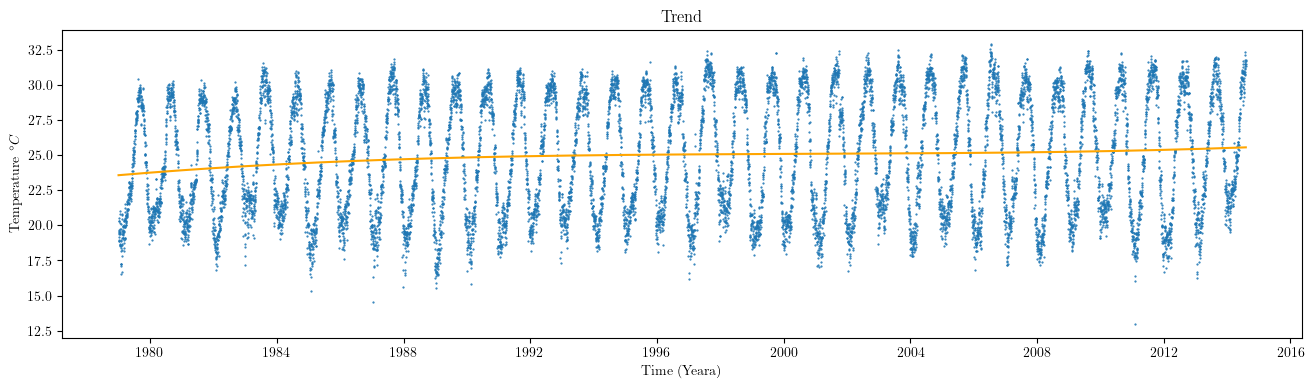

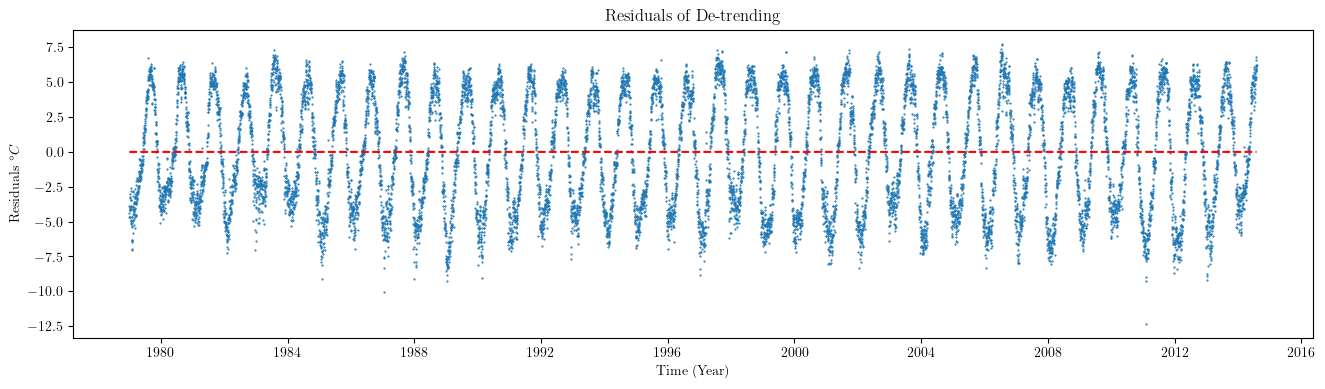

In [ ]:
plt.figure(figsize=ts_fig)
plt.scatter(dt_train, y_train, s=0.3)
plt.plot(dt_train, p2(x_train), '-', c='orange')
plt.title('Trend')
plt.ylabel(r'Temperature $^\circ C$')
plt.xlabel('Time (Yeara)')
plt.gcf().savefig("Figure 2 (a).svg", format='svg', bbox_inches='tight')
plt.show()

detrend = y_train - p2(x_train)
plt.figure(figsize=ts_fig)
plt.scatter(dt_train, detrend, s=0.3)
plt.plot(dt_train, [0] * len(dt_train), c="red", linestyle="--")
plt.title('Residuals of De-trending')
plt.xlabel('Time (Year)')
plt.ylabel(r'Residuals $^\circ C$')
plt.gcf().savefig("Figure 2 (b).svg", format='svg', bbox_inches='tight')
plt.show()

# Seasonal component

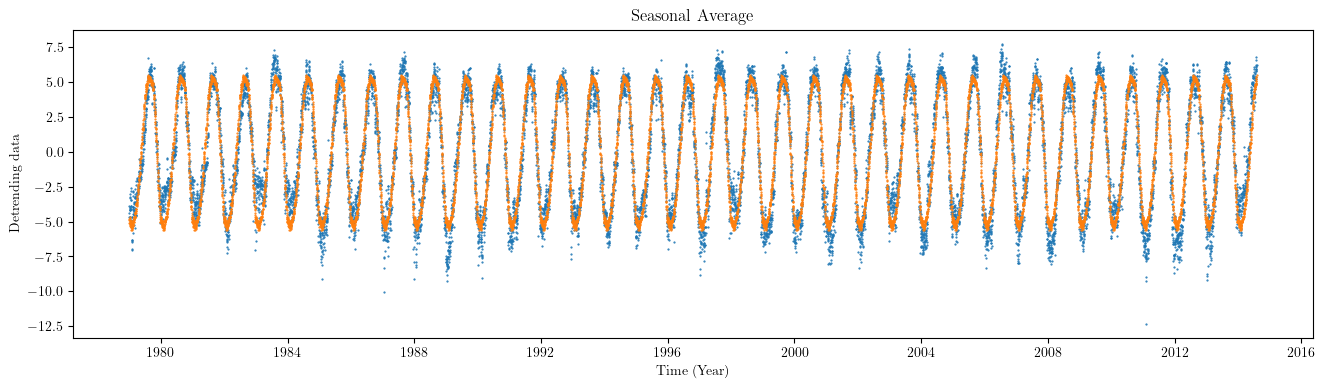

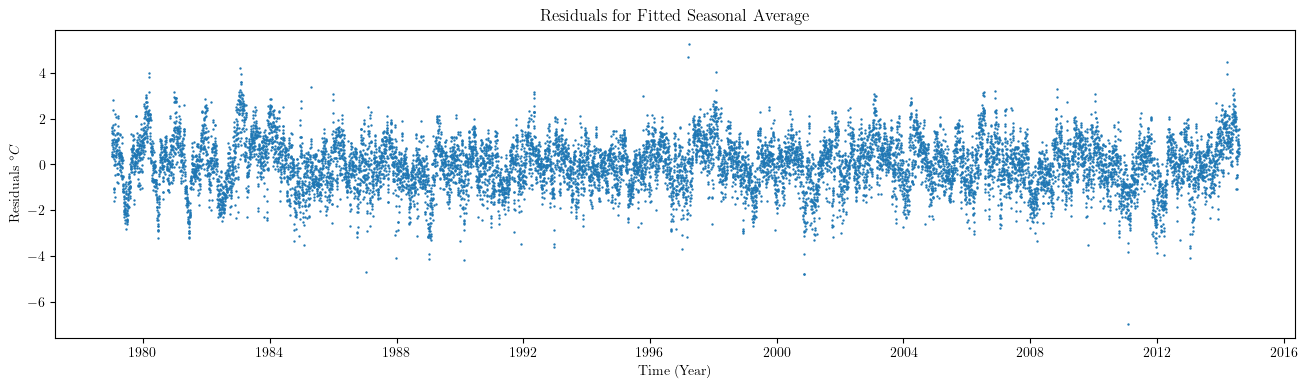

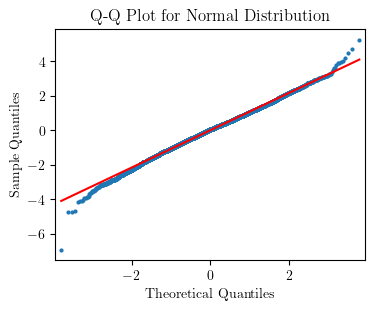

15300.66551198239
39742.71244090017 42477.72233783855
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     456.6
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        07:12:41   Log-Likelihood:                -19505.
No. Observations:               13000   AIC:                         3.974e+04
Df Residuals:                   12634   BIC:                         4.248e+04
Df Model:                         365                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [ ]:
import statsmodels.api as sm

# mon = pd.get_dummies(df['mon'][:split_idx], prefix='Month', drop_first=False)
# model_seasonal_mean = sm.OLS(detrend, mon).fit()
# seasonal_mean = model_seasonal_mean.predict(mon)

day = pd.get_dummies(df['dt'][:split_idx].dt.dayofyear, prefix='Day', drop_first=False)
model_seasonal_mean = sm.OLS(detrend, day).fit()
seasonal_mean = model_seasonal_mean.predict(day)

plt.figure(figsize=ts_fig)
plt.scatter(dt_train, detrend, s=0.3)
plt.scatter(dt_train, seasonal_mean, s=0.3)
plt.title("Seasonal Average")
plt.ylabel('Detrending data')
plt.xlabel('Time (Year)')
plt.gcf().savefig("Figure 3 (a).svg", format='svg', bbox_inches='tight')
plt.show()

detrend_deseasonal = detrend - seasonal_mean

plt.figure(figsize=ts_fig)
plt.scatter(dt_train, detrend_deseasonal, s=0.5)
plt.xlabel('Time (Year)')
plt.ylabel(r'Residuals $^\circ C$')
plt.title('Residuals for Fitted Seasonal Average')
plt.gcf().savefig("Figure 3 (b).svg", format='svg', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=dis_fig)
qqplot(detrend_deseasonal, line='s', ax=ax, markersize=2)
plt.title('Q-Q Plot for Normal Distribution')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.gcf().savefig("Figure 3 (c).svg", format='svg', bbox_inches='tight')
plt.show()

print(np.sum(detrend_deseasonal**2))

sigma = np.std(detrend_deseasonal)
n = len(detrend)
log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(sigma**2) - 0.5 * np.sum((detrend_deseasonal / sigma)**2)

# AIC, BIC
k = len(model_seasonal_mean.params)
aic = 2 * k - 2 * log_likelihood
bic = k * np.log(n) - 2 * log_likelihood
print(aic, bic)
print(model_seasonal_mean.summary())

In [ ]:
from scipy.optimize import leastsq

period = 365.25

t = np.arange(len(detrend))
X = np.column_stack([
    np.sin(2 * np.pi * t / period),
    np.cos(2 * np.pi * t / period)
])

def func(params, t):
    return params[0] * np.sin(2 * np.pi * t / period) + params[1] * np.cos(2 * np.pi * t / period)

def error(params, t, y):
    return y - func(params, t)

initial_params = [1, 1]

params_optimized, success = leastsq(error, initial_params, args=(t, detrend), maxfev=1000)

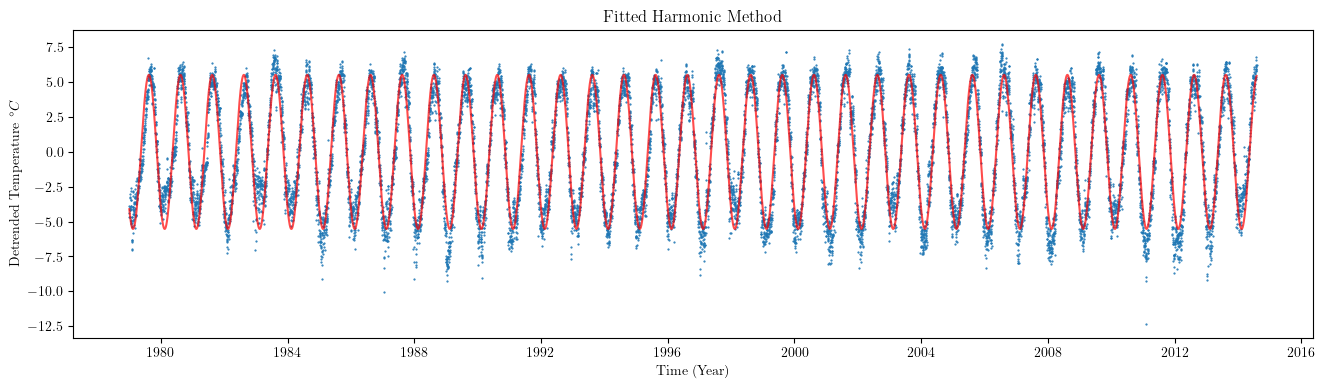

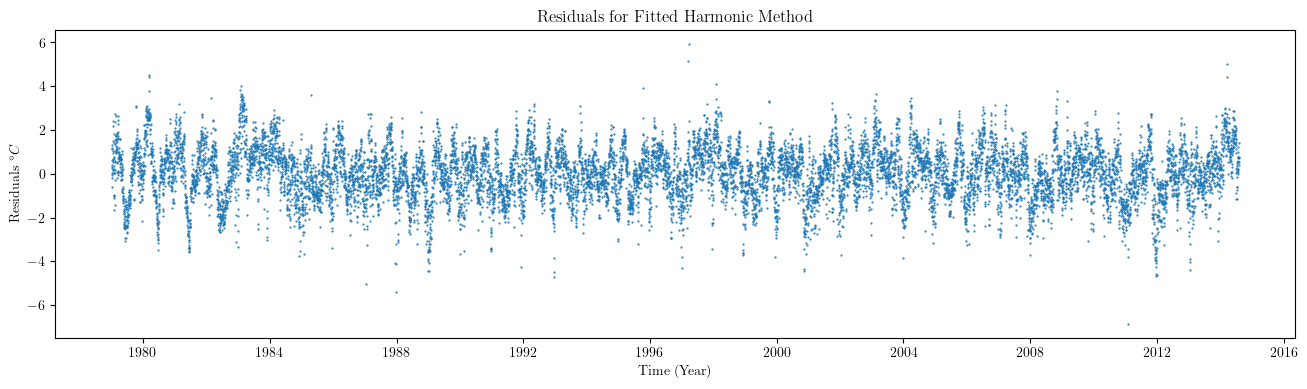

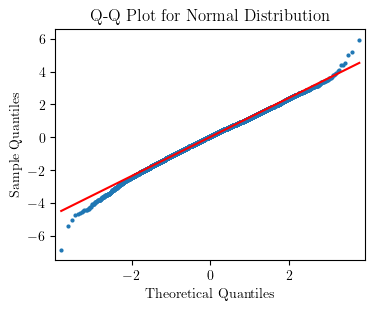

18477.039303850303
AIC: 41466.93575603941, BIC: 41481.8811653123


In [ ]:
seasonal = func(params_optimized, t)

detrend_deseasonal = detrend - seasonal

detrend = y_train - p2(x_train)
plt.figure(figsize=ts_fig)
plt.scatter(dt_train, detrend, s=0.3)
plt.plot(dt_train, seasonal, c='red', alpha=0.7)
plt.title('Fitted Harmonic Method')
plt.ylabel(r'Detrended Temperature $^\circ C$')
plt.xlabel('Time (Year)')
plt.gcf().savefig("Figure 4 (a).svg", format='svg', bbox_inches='tight')
plt.show()

plt.figure(figsize=ts_fig)
plt.scatter(dt_train, detrend_deseasonal, s=0.3)
plt.title('Residuals for Fitted Harmonic Method')
plt.ylabel(r'Residuals $^\circ C$')
plt.xlabel('Time (Year)')
plt.gcf().savefig("Figure 4 (b).svg", format='svg', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=dis_fig)
qqplot(detrend_deseasonal, line='s', ax=ax, markersize=2)
plt.title('Q-Q Plot for Normal Distribution')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.gcf().savefig("Figure 4 (c).svg", format='svg', bbox_inches='tight')
plt.show()

print(np.sum(detrend_deseasonal**2))
sigma = np.std(detrend_deseasonal)
n = len(detrend)
log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(sigma**2) - 0.5 * np.sum((detrend_deseasonal / sigma)**2)

# AIC, BIC
k = len(params_optimized)
aic = 2 * k - 2 * log_likelihood
bic = k * np.log(n) - 2 * log_likelihood

print(f"AIC: {aic}, BIC: {bic}")

# ARMA

<Figure size 400x200 with 0 Axes>

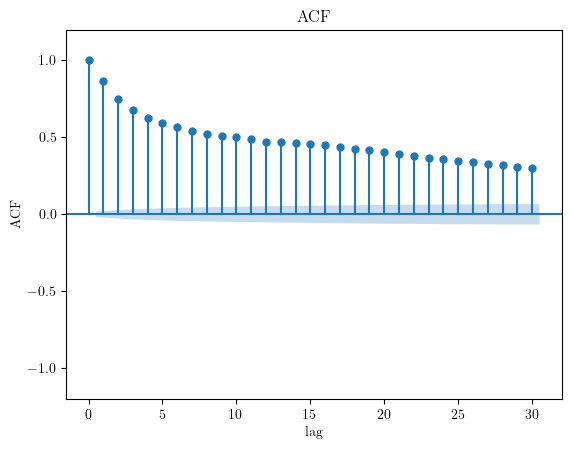

<Figure size 400x200 with 0 Axes>

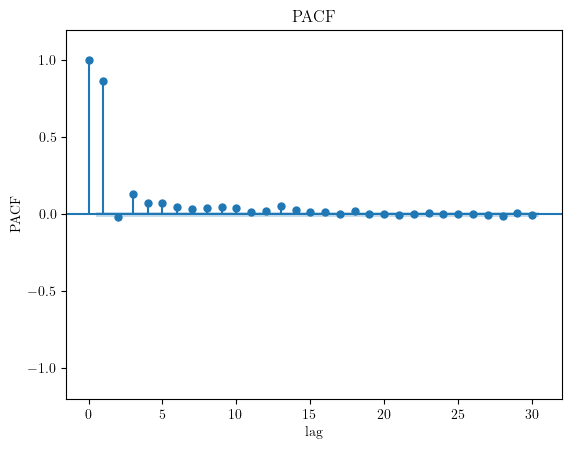

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(4, 2))
plot_acf(detrend_deseasonal, lags=30)
plt.title('ACF')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.ylim(-1.2, 1.2)
plt.gcf().savefig("Figure 5 (a).svg", format='svg', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4, 2))
plot_pacf(detrend_deseasonal, lags=30)
plt.title('PACF')
plt.xlabel('lag')
plt.ylabel('PACF')
plt.ylim(-1.2, 1.2)
plt.gcf().savefig("Figure 5 (b).svg", format='svg', bbox_inches='tight')
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# We should check more ljung-box test of others lags
model = ARIMA(detrend_deseasonal, order=(14, 0, 0))
results = model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                13000
Model:                ARIMA(14, 0, 0)   Log Likelihood              -11461.268
Date:                Mon, 09 Dec 2024   AIC                          22954.536
Time:                        07:20:44   BIC                          23074.100
Sample:                             0   HQIC                         22994.486
                              - 13000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0218      0.075      0.290      0.772      -0.126       0.169
ar.L1          0.8531      0.007    122.110      0.000       0.839       0.867
ar.L2         -0.1271      0.010    -12.533      0.0

In [ ]:
lags = 50  # Number of lags to test
lb_test = sm.stats.acorr_ljungbox(results.resid, lags=lags, return_df=True)
lb_test

,lb_stat,lb_pvalue
1,0.026631,0.870368
2,0.054285,0.973222
3,0.084645,0.993614
4,0.129366,0.997996
5,0.280478,0.997994
6,0.395299,0.998890
7,0.495343,0.999463
8,0.653496,0.999634
9,0.875419,0.999675
10,1.198498,0.999608


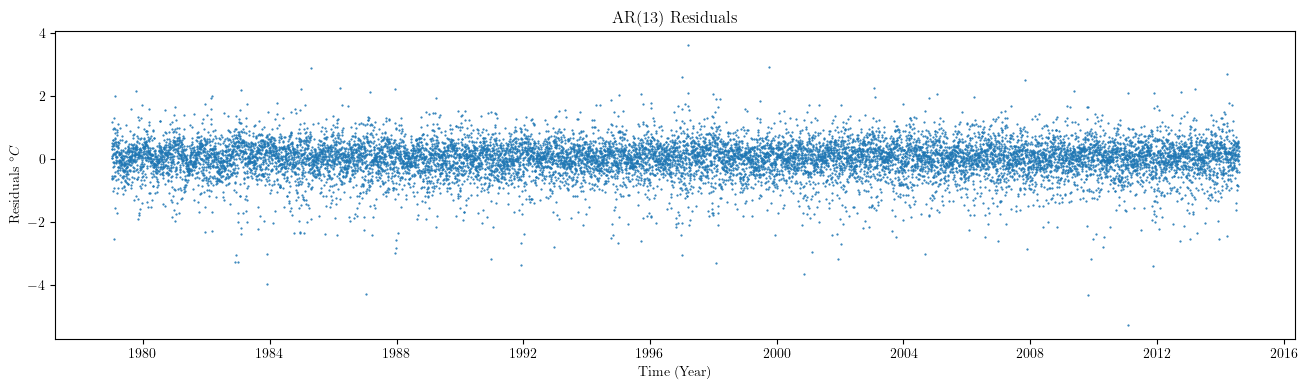

<Figure size 400x300 with 0 Axes>

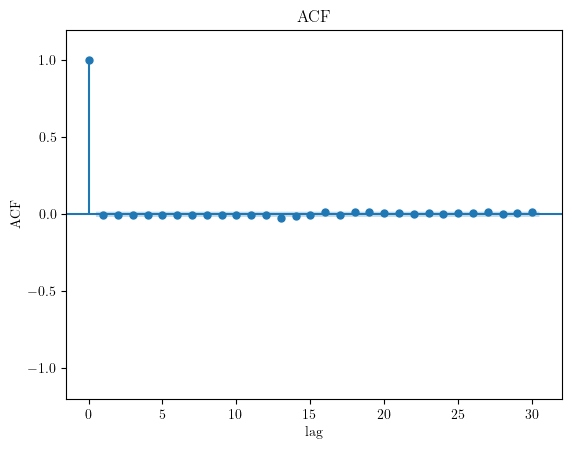

<Figure size 400x300 with 0 Axes>

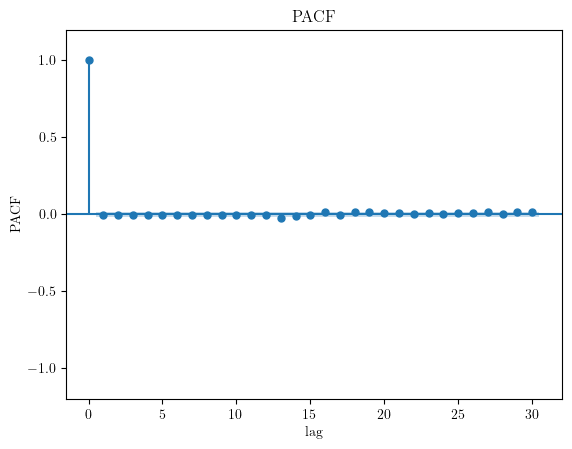

In [ ]:
import statsmodels.api as sm

plt.figure(figsize=ts_fig)
plt.scatter(dt_train, results.resid, s=0.3)
plt.title('AR(13) Residuals')
plt.ylabel(r'Residuals $^\circ C$')
plt.xlabel('Time (Year)')
plt.gcf().savefig("Figure 6 (a).svg", format='svg', bbox_inches='tight')
plt.show()

plt.figure(figsize=dis_fig)
plot_acf(results.resid, lags=30)
plt.title('ACF')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.ylim(-1.2, 1.2)
plt.gcf().savefig("Figure 6 (b).svg", format='svg', bbox_inches='tight')
plt.show()

plt.figure(figsize=dis_fig)
plot_pacf(results.resid, lags=30)
plt.title('PACF')
plt.xlabel('lag')
plt.ylabel('PACF')
plt.ylim(-1.2, 1.2)
plt.gcf().savefig("Figure 6 (c).svg", format='svg', bbox_inches='tight')
plt.show()

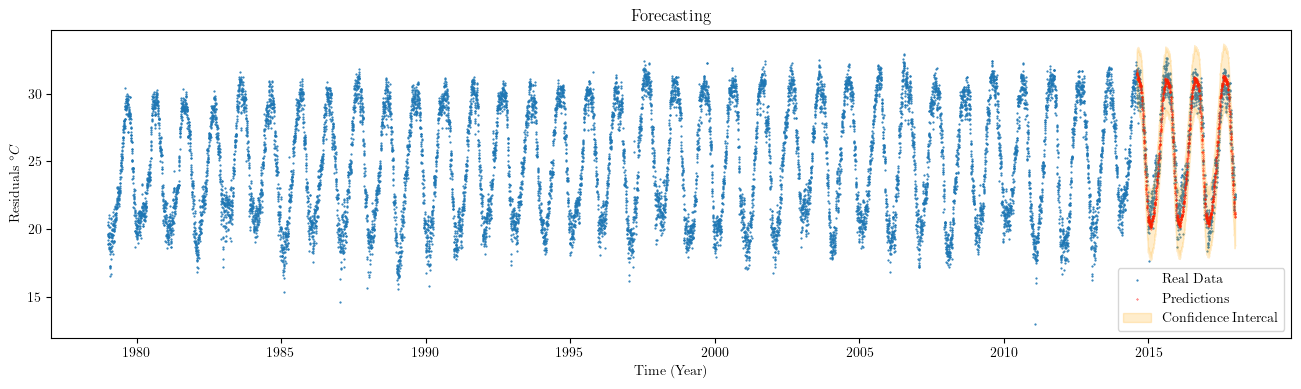

In [ ]:
idx_test = np.arange(len(y_train), len(y_train) + len(y_test))
z_critical = 1.96

future_predictions_trend = p2(idx_test)

# future_predictions_seasonal = func(params_optimized, idx_test)
future_predictions_seasonal = model_seasonal_mean.predict(pd.get_dummies(df['dt'][idx_test].dt.dayofyear, prefix='Day', drop_first=False))

forecast_results = results.get_forecast(steps=len(y_test))
future_predictions_arma = forecast_results.predicted_mean
standard_errors = forecast_results.se_mean

conf_int_arma = forecast_results.conf_int(alpha=0.05)
std_error_arma = (conf_int_arma[:, 1] - conf_int_arma[:, 0]) / (2 * z_critical)

future_predictions = future_predictions_trend + future_predictions_seasonal + future_predictions_arma

lower_bound, upper_bound = future_predictions - z_critical * standard_errors, future_predictions + z_critical * standard_errors

plt.figure(figsize=ts_fig)
plt.scatter(dt, y, s=0.3, label='Real Data')
plt.scatter(dt_test, future_predictions, s=0.1, c='red', label='Predictions')
plt.fill_between(dt_test, lower_bound, upper_bound, color='orange', alpha=0.2, label='Confidence Intercal')
# plt.xlim(12000, 15000)
plt.title("Forecasting")
plt.ylabel(r'Residuals $^\circ C$')
plt.xlabel('Time (Year)')
plt.legend()
plt.gcf().savefig("Figure 7.svg", format='svg', bbox_inches='tight')
plt.show()


# Model performance evaluation

In [ ]:
# Root mean square error (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Mean relative prediction error
def mean_relative_prediction_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Empirical coverage rate
def empirical_coverage_rate(y_true, y_lower, y_upper):
    coverage = np.sum((y_true >= y_lower) & (y_true <= y_upper)) / len(y_true)
    return coverage

rmse_value = rmse(y_test, future_predictions)
print(f"RMSE: {rmse_value}")

mrpe_value = mean_relative_prediction_error(y_test, future_predictions)
print(f"Mean Relative Prediction Error: {mrpe_value}")

ecr_value = empirical_coverage_rate(y_test, lower_bound, upper_bound)
print(f"Empirical Coverage Rate: {ecr_value}")

RMSE: 1.1071871485661788
Mean Relative Prediction Error: 0.03478191047830823
Empirical Coverage Rate: 0.9646586345381526


In [ ]:
# Harmonic
# RMSE: 1.2381757661437527
# Mean Relative Prediction Error: 0.038255006203806965
# Empirical Coverage Rate: 0.9357429718875502

# Seasonal mean
# RMSE: 1.1071871485661788
# Mean Relative Prediction Error: 0.03478191047830823
# Empirical Coverage Rate: 0.9646586345381526